In [1]:
import pandas as pd
import numpy as np
import simulations.gbm as sim
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
import seaborn

seaborn.set()

Following dataset has entries for 4 nearest delivery months for WTI oil

In [2]:
#raw_data = pd.read_excel("PET_PRI_FUT_S1_D.xls", sheet_name=1, header=2)
raw_data1 = pd.read_csv("CLN20.NYM.csv")
raw_data2 = pd.read_csv("CLQ20.NYM.csv")
# also at https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls
raw_data1.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
618,2020-04-05,32.330002,32.330002,32.330002,32.330002,32.330002,0.0
619,2020-04-06,32.439999,32.959999,31.520000,32.799999,32.799999,40422472.0
620,2020-04-07,32.509998,33.340000,31.469999,32.040001,32.040001,121624.0
621,2020-04-08,32.810001,33.619999,31.889999,33.470001,33.470001,47884520.0
622,2020-04-09,33.040001,35.180000,31.809999,32.029999,32.029999,59018037.0


In [3]:
# set date as index for this time series
raw_data1 = raw_data1.set_index("Date")
raw_data2 = raw_data2.set_index("Date")

raw_data1 = raw_data1.iloc[:,3]
raw_data2 = raw_data2.iloc[:,3]
raw_data1.tail()

Date
2020-04-05    32.330002
2020-04-06    32.799999
2020-04-07    32.040001
2020-04-08    33.470001
2020-04-09    32.029999
Name: Close, dtype: float64

For nearest 1 month calendar spread, contract 1 and contract 2 has to be used. For May 2020, the option expiration is 20 April 2020 (day before the nearest of the two futures contracts expires), current calendar is available [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_product_calendar_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).  
The value of a calendar spread is for call (FC1-FC2-S)*1000 or 0 if it is negative. FC1 and FC2 are settlement prices when the option expires.

In [4]:
#selected = raw_data.loc["2015-01-01":, raw_data.columns[0]:raw_data.columns[1]].copy()
selected = pd.DataFrame({"Jul 20":raw_data1,"Aug 20":raw_data2})
selected.index = pd.to_datetime(selected.index)
selected = selected.asfreq(BDay())
selected = selected.fillna(method='ffill').dropna()
selected.tail()

,Jul 20,Aug 20
2020-04-03,33.000000,33.599998
2020-04-06,32.799999,33.750000
2020-04-07,32.040001,32.930000
2020-04-08,33.470001,34.320000
2020-04-09,32.029999,33.270000


In [5]:
selected = selected["2019-07-29":]

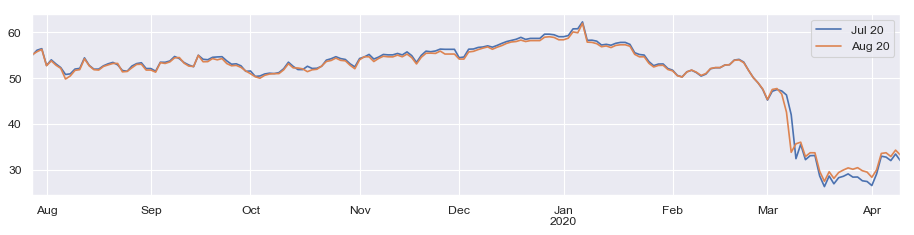

In [6]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in selected.columns:
    selected[col].plot(legend=True)
plt.show()

In [7]:
#logs = np.log(selected/selected.shift(1))
change = selected.pct_change()
#logs = logs.dropna()
change = change.dropna()

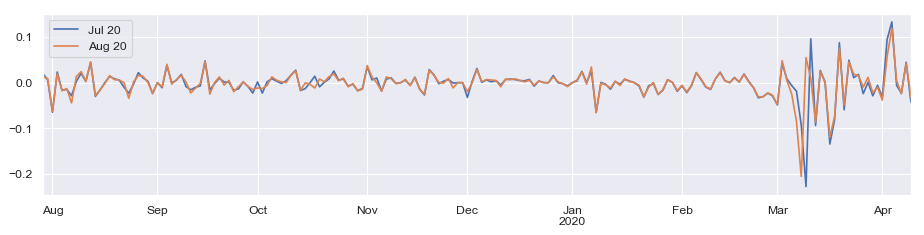

In [8]:
plt.figure(figsize=(14, 3), dpi= 80)
for col in change.columns:
    change[col].plot(legend=True)
plt.show()

When using two different products, it is necessary to include their correlation into simulation, so that the simulated prices move like in real life. Since both timeseries are futures on the same commodity and the only difference is their settlement date, the correlation is very close to 1. (following three lines of code show how to compute correlation in python using numpy)

In [9]:
corres1 = np.corrcoef(change[change.columns[0]],change[change.columns[1]])
cor1 = corres1[1,0]
cor1

0.6949097077560504

In [10]:
print(change.index.min())
print(change.index.max())

2019-07-30 00:00:00
2020-04-09 00:00:00


In [11]:
data3 = change[:"2020-03-05"] 
cor3 = np.corrcoef(data3[data3.columns[0]],data3[data3.columns[1]])
cor3 = cor3[1,0]
cor3


0.9584408057671194

In [12]:
print(data3.index.min())
print(data3.index.max())

2019-07-30 00:00:00
2020-03-05 00:00:00


In [13]:
import scipy.stats as sps


## Calendar spread simulation

Function simulates paths with a GBM model. Random noise is generated from normal distribution, the time gap is assumed to be 1 day, so delta t is 1.

In [14]:
from simulations.gbm import calendar_spread_gbm

### Find number of steps until expiration

In [15]:
from auxiliary.ContractCalendar import ContractCalendar

calendar_option_contract = ContractCalendar.wti_1m_spread_option()
calendar_option_contract.calendar.head()

,Contract Month,Product Code,First Trade,Last Trade,Settlement
0,May 2020 Crude Oil Financial Calendar Spread O...,7AK20,2015-04-21,2020-04-20,2020-04-20
1,June 2020 Crude Oil Financial Calendar Spread ...,7AM20,2015-05-19,2020-05-18,2020-05-18
2,July 2020 Crude Oil Financial Calendar Spread ...,7AN20,2015-06-23,2020-06-19,2020-06-19
3,August 2020 Crude Oil Financial Calendar Sprea...,7AQ20,2015-07-21,2020-07-20,2020-07-20
4,September 2020 Crude Oil Financial Calendar Sp...,7AU20,2015-08-20,2020-08-19,2020-08-19


In [16]:
option_expiration = calendar_option_contract.calendar[calendar_option_contract.calendar["Product Code"]=="7AN20"].iloc[0,-1]
option_expiration

Timestamp('2020-06-19 00:00:00')

In [17]:
all_days = ContractCalendar.get_business_days(start=selected.index[-1], end=option_expiration)
len(all_days)

52

In [18]:
no_of_steps = len(all_days) - 1 # I have to subtract 1 because the initial value is the first day
no_of_steps

51

### Estimate the discount rate

One part of an option's price is it's time value. After performing a simulation to estimate the option's final value, it is necessary to transform that value into a present one. That is done by discounting the value at expiration by a risk free rate. There are multiple possibilites from which risk free rate can be chosen:
 * Domestic risk free rates (Treasury bills, bonds or notes) [Risk free rates in wacc calculation](http://www.eru.cz/documents/10540/5475589/Navrh-zasad-cenove-regulace-2021-2025-pro-verejnou-konzultaci.pdf/f6df3fd5-d5af-425f-a53f-ecbddd4447fe)
 * Interest rates (LIBOR, PRIBOR)
 
Considering the Czech Republic, PRIBOR seems like the best best choice since it is regularly [updated](https://www.cnb.cz/en/financial-markets/money-market/pribor/fixing-of-interest-rates-on-interbank-deposits-pribor/) and offers several term options (1 month up to 1 year) to choose from, which is convenient for option pricing (unless it's an option that expires in a distant future, in that case bonds would be more suitable). [Emission of treasury bills](https://www.mfcr.cz/cs/verejny-sektor/rizeni-statniho-dluhu/emise-statnich-dluhopisu/emisni-kalendare-spp/2020/emisni-kalendar-statnich-pokladnicnich-p-37569) is less frequent with lower selection of due dates.  
<br>
In the following simulation, 1 month PRIBOR rate (1.04%) is used for `discount_rate`. Since the function expects year value, I will multiply the PRIBOR 1 month rate by 12, this is offseted by using 1/12 for the `maturity` parameter.

### Simulation

1 month calendar spread put option, strike is set to 0.1 dollars per barrel, maturity is in one month.

### Select how many previous values to use

In [19]:
from auxiliary.distribution_fit import distribution_fit
history_size = 20

change_sliced = change.iloc[-history_size:,:]

In [20]:
#par_jul = distribution_fit(change_sliced["Jul 20"])
#par_jul

In [21]:
#par_aug = distribution_fit(change_sliced["Aug 20"])
#par_aug

In [22]:
std_change = change_sliced.std()
std_change

Jul 20    0.061986
Aug 20    0.053416
dtype: float64

In [23]:
mean_change = change_sliced.mean()
mean_change

Jul 20    0.001497
Aug 20    0.001889
dtype: float64

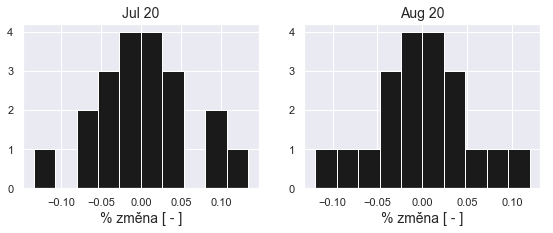

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3))
fig.tight_layout()
ax1.hist(change_sliced["Jul 20"], color="k", bins=10)
ax1.set_title("Jul 20", fontsize=14)
ax1.set_xlabel("% změna [ - ]",fontsize=14)
ax2.hist(change_sliced["Aug 20"], color="k", bins=10)
ax2.set_title("Aug 20",fontsize=14)
ax2.set_xlabel("% změna [ - ]",fontsize=14)
fig.savefig('calendar_hist.pdf', format='pdf', bbox_inches='tight')

In [25]:
from statsmodels.stats.stattools import jarque_bera
j1 = jarque_bera(change_sliced["Jul 20"])
j2 = jarque_bera(change_sliced["Aug 20"])
print(j1)
print(j2)
pd.DataFrame({"Jul 20":j1,"Aug 20":j2}, index=["JB hodnota","p hodnota", "šikmost", "špičatost"])

(0.06623652306039295, 0.9674241437640796, 0.10434466553232534, 3.1895589374634183)
(0.13366986337228465, 0.9353495851733783, -0.03963128573223247, 3.3925828330576646)


,Jul 20,Aug 20
JB hodnota,0.066237,0.133670
p hodnota,0.967424,0.935350
šikmost,0.104345,-0.039631
špičatost,3.189559,3.392583


In [26]:
corres1 = np.corrcoef(change_sliced[change_sliced.columns[0]],change_sliced[change_sliced.columns[1]])
cor1 = corres1[1,0]
cor1

0.987763820866162

In [27]:
print(change_sliced.index.max())
print(change_sliced.index.min())

2020-04-09 00:00:00
2020-03-13 00:00:00


In [28]:
from simulations.simulations import spread_simulation_gbm_final
position_flag = "p"
initial_price1 = selected.iloc[-1,0]
initial_price2 = selected.iloc[-1,1]
strike = -3
sim = 10000
steps = no_of_steps
loc1 = mean_change[0]
loc2 = mean_change[1]
scale1 = std_change[0]
scale2 = std_change[1]
cor = cor1

np.random.seed(19121995)

total, paths, payoffs = spread_simulation_gbm_final(position_flag=position_flag,
                                     initial_price1=initial_price1,
                                     initial_price2=initial_price2,
                                     strike=strike,
                                     simulations=sim,
                                     steps=steps,
                                     loc1=loc1,
                                     loc2=loc2,
                                     scale1=scale1,
                                     scale2=scale2,
                                     cor=cor,
                                    )

In [29]:
discount_rate = 0.0101 * 6 # chosen discount rate
maturity = no_of_steps/252 

In [30]:
(np.exp(-discount_rate*maturity)/sim)*total

0.5929867417706925

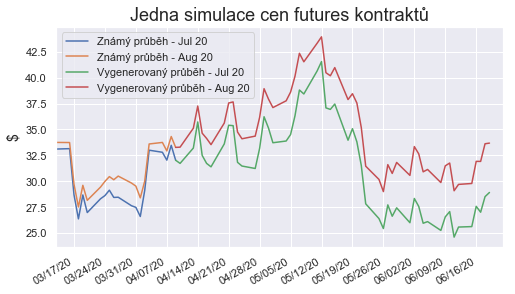

In [31]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4.5))
ax.set_title("Jedna simulace cen futures kontraktů", fontsize=18)
ax.plot(selected.iloc[-20:,0], label="Známý průběh - Jul 20")
ax.plot(selected.iloc[-20:,1], label="Známý průběh - Aug 20")
for path in paths[0][0:1]:
    ax.plot(all_days, path, label="Vygenerovaný průběh - Jul 20")
for path in paths[1][0:1]:
    ax.plot(all_days, path, label="Vygenerovaný průběh - Aug 20")
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(selected.index[-20], all_days[-1]+BDay())
fig.autofmt_xdate()
ax.legend()
plt.show()
fig.savefig('sim_calendar.pdf', format='pdf', bbox_inches='tight')

In [32]:
params = pd.DataFrame(
                        {"Params":[initial_price1, initial_price2, strike, maturity, discount_rate * 100, scale1 * np.sqrt(252) * 100, scale2 * np.sqrt(252) * 100, cor]},
                        index=["S1","S2","X","Maturity","r","sigma1","sigma2","cor"]
                        )
params

,Params
S1,32.029999
S2,33.270000
X,-3.000000
Maturity,0.202381
r,6.060000
sigma1,98.400333
sigma2,84.795797
cor,0.987764


The contract is more closely described [here](https://www.cmegroup.com/content/dam/cmegroup/rulebook/NYMEX/3/397.pdf) and current info about price and volumes are [here](https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude_contractSpecs_options.html?optionProductId=2952&optionExpiration=2952-K0#optionProductId=2952).

### Compare result
This section contains calculations of option prices and comparisons with simulation result from previous part. For this purpose I will use Excel files that come with the book The Complete Guide to Option Pricing Formulas which contain functions that are ready for use to evaluate prices of vast variety of functions.  
<br>
The function I'm going to use accepts additional parameters, cost of carry for both assets (I will use value of 0) and quantity of both assets (I will use value of 1).

The values are now in a correct form to be inputted into the function.

Additional setup of the excel for this formula to be noted:  
 * Dropdown selection above the parameters input should be set to "years"
 * First dropdown selection that is to the right of the parameters input should be set to continuous

In [33]:
selected.iloc[-1,0]


32.029999

In [34]:
selected.iloc[-1,1]

33.27

In [35]:
maturity

0.20238095238095238

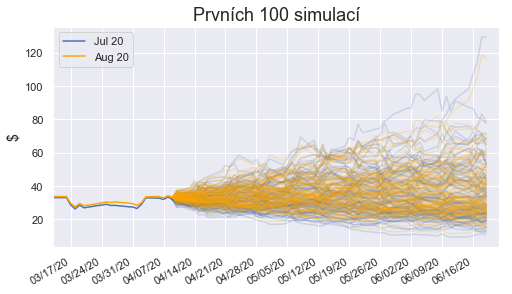

In [36]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4.5))
ax.set_title("Prvních 100 simulací", fontsize=18)
ax.plot(selected.iloc[-20:,0],c="b")
ax.plot(selected.iloc[-20:,1],c="orange")
for path in paths[0][0:100]:
    ax.plot(all_days, path, c="b", alpha=0.2)
for path in paths[1][0:100]:
    ax.plot(all_days, path, c="orange", alpha=0.2)
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(selected.index[-20], all_days[-1]+BDay())
fig.autofmt_xdate()
ax.legend()
plt.show()
fig.savefig('sim_calendar_100.pdf', format='pdf', bbox_inches='tight')

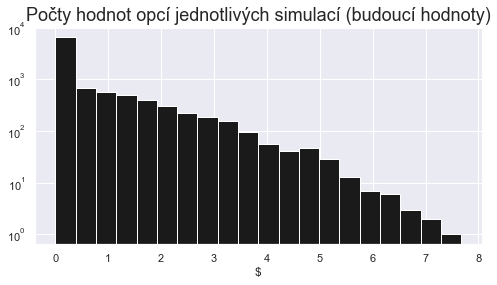

In [63]:
s = pd.Series(payoffs)
s[s>0]
plt.figure(figsize=(8, 4))
plt.title("Počty hodnot opcí jednotlivých simulací (budoucí hodnoty)", fontsize=18)
plt.xlabel("$")
plt.yscale('log', nonposy='clip')
plt.hist(s, bins=20, color="k")
plt.plot()
plt.savefig('sim_calendar_payoffs.pdf', format='pdf', bbox_inches='tight')

In [42]:
s.std()

1.0579261577353498

In [49]:
se = s.std()/np.sqrt(sim)
se

0.010579261577353498